# import and functions 

In [24]:
import os
import pandas as pd
import numpy as np  
from datetime import datetime
import matplotlib.pyplot as plt
import cv2
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import shutil
from datetime import datetime


def process_camera_data(Camera_ts_raw):

    Camera_ts = convert_uncycle_Timestamps(Camera_ts_raw)

    #check for dropped frames:
    check_timestamps(Camera_ts, Frame_rate = 60)
    # Find triggers:
    Camera_trig_states = find_trigger_states(Camera_ts_raw)
    #check if triggers are working:
    result = np.max(Camera_trig_states) == np.min(Camera_trig_states)
    
    # #pull out video name
    # video_name = [TimeStampPath.split("\\")[-1].split(".")[0] + '-camera-timestamp-data']

    if not result:

        # make camera dataframe:
        Camera_dataframe = pd.DataFrame(
            {'Time Stamps': Camera_ts,
            'Trigger State': Camera_trig_states,
            # 'DataPath': ([TimeStampPath] * len(Camera_ts))
            })
        
    return Camera_dataframe

def converttime(time):
    #offset = time & 0xFFF
    cycle1 = (time >> 12) & 0x1FFF
    cycle2 = (time >> 25) & 0x7F
    seconds = cycle2 + cycle1 / 8000.
    return seconds

def uncycle(time):
    cycles = np.insert(np.diff(time) < 0, 0, False)
    cycleindex = np.cumsum(cycles)
    return time + cycleindex * 128

def convert_uncycle_Timestamps(Camera_ts):
    ##################   Convert the timestamps into seconds and uncycle them:
    t_stamps = {}  
    stamps_s = []
    for indx, row in Camera_ts.iterrows():
        if row.trigger > 0: 
            timestamp_new = converttime(int(row.timestamps))
            stamps_s.append(timestamp_new)
        # else:    
        #     raise ValueError('Timestamps are broken')
    t_stamps = uncycle(stamps_s)
    t_stamps = t_stamps - t_stamps[0] # make first timestamp 0 and the others relative to this 
    return(t_stamps)

def check_timestamps(t_stamps, Frame_rate):
    # plot 1/(diff between time stamps). This tells you roughly the frequency and if you've droppped frames.
    Frame_gaps = 1/np.diff(t_stamps)
    Frames_dropped = 0
    for gaps in Frame_gaps:
        if gaps < (Frame_rate-5) or gaps > (Frame_rate+5):
            Frames_dropped = Frames_dropped + 1
    print('Frames dropped = ' + str(Frames_dropped))

    plt.suptitle('Frame rate = ' + str(Frame_rate) + 'fps', color = 'red')
    frame_gaps = plt.hist(Frame_gaps, bins=100)
    plt.xlabel('Frequency')
    plt.ylabel('Number of frames')
    
def find_trigger_states(Camera_ts_raw):
    triggers = Camera_timestamps.trigger.values[np.where(Camera_timestamps.loc[:,'trigger']>0)]
    down_state = list(triggers)[0]
    down_state_times = np.where(triggers == down_state)
    Triggers_temp = np.ones(len(triggers))
    for index in down_state_times:
        Triggers_temp[index] = 0
    trigger_state = Triggers_temp
    return trigger_state

def load_video(path):
    return cv2.VideoCapture(path)

def get_total_frames(cap):
    return int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

def calculate_interval(total_frames, num_frames):
    return total_frames // num_frames

def process_frame(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    gray_frame = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2GRAY)
    blurred_frame = cv2.GaussianBlur(gray_frame, (15, 15), 0)
    circles = cv2.HoughCircles(blurred_frame, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50, param1=50, param2=30, minRadius=25, maxRadius=40)
    return frame_rgb, circles

def draw_circles(frame_rgb, circles):
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            cv2.circle(frame_rgb, (x, y), r, (0, 255, 0), 4)
            cv2.rectangle(frame_rgb, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
        return len(circles)
    return 0

def analyze_video_type(cam_path, start_time, end_time, num_frames=20):
    cap = load_video(cam_path)
    total_frames = get_total_frames(cap)
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)
    interval = (end_frame - start_frame) // num_frames
    
    fig, axes = plt.subplots(2, int(np.ceil(num_frames / 2)), figsize=(15, 6))
    circles_count = []

    for i in range(num_frames):
        frame_number = start_frame + i * interval
        if frame_number > end_frame:
            break
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()
        if ret:
            frame_rgb, circles = process_frame(frame)
            count = draw_circles(frame_rgb, circles)
            circles_count.append(count)
            
            ax = axes[i // int(np.ceil(num_frames / 2)), i % int(np.ceil(num_frames / 2))]
            ax.imshow(frame_rgb)
            ax.set_title(f'Frame {frame_number}')
            ax.axis('off')
        else:
            print(f"Error: Could not read frame at position {frame_number}.")
            circles_count.append(0)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(num_frames), circles_count, marker='o')
    plt.xlabel('Frame Index')
    plt.ylabel('Number of Circles Detected')
    plt.title('Number of Circles Detected in Each Frame')
    plt.show()
    return circles_count

def convert_seconds(total_seconds):
    hours = total_seconds // 3600
    minutes = (total_seconds % 3600) // 60
    seconds = total_seconds % 60
    return hours, minutes, seconds


def check_time_dropped(times,Frame_rate = 60):
    
    # Calculate the expected time difference between frames
    expected_diff = 1 / Frame_rate

    # Calculate the actual time differences between frames
    actual_diffs = np.diff(times)

    # Identify where frames have been dropped
    dropped_frames = np.where((actual_diffs < expected_diff - 0.001) | (actual_diffs > expected_diff + 0.001))[0]

    # Calculate the total time dropped
    total_time_dropped = np.sum(actual_diffs[dropped_frames] - expected_diff)

    print(f"Total frames dropped: {len(dropped_frames)}")
    print(f"Total time dropped is approximatley: {total_time_dropped} seconds")

    # Example usage
    total_seconds = total_time_dropped
    hours, minutes, seconds = convert_seconds(total_seconds)
    print(f"{total_seconds} seconds is equal to {hours} hours, {minutes} minutes, and {seconds} seconds.")
    


def convert_date_format(date_str):
    date_obj = datetime.strptime(date_str, '%Y%m%d')
    formatted_date = date_obj.strftime('%d-%m-%Y')
    return formatted_date

    

# pull in all paths

In [15]:
base_path = r"Z:\projects\sequence_squad\revision_data\lars_recordings\video\\"
save_path_base = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"

files_to_process = []
full_files_to_process = []
for mouse_file in os.listdir(base_path):
    mouse_base = os.path.join(base_path, mouse_file)
    for recording in os.listdir(mouse_base):
        full_file = os.path.join(mouse_base, recording)
        for file in os.listdir(full_file):
            if '.csv' in file:
                
                ###### ADDED TO MAKE IT HACKILY WORK FOR THE NEW DATA
                if 'seq052' in file or 'seq059' in file or 'seq054' in file:
                ##################################################                
    
                    full_files_to_process += [full_file]
                    files_to_process+=[file]
                    
                    mouse_file = full_file.split('\\')[-2]
                    mouse_file = mouse_file.lower()
                    if 'ap5' in mouse_file:
                        mouse_file = mouse_file.split('_')[0] + mouse_file.split('_')[-1]
                    
                    ## handle weird differences in data naming
                    if not mouse_file in file:
                        if 'camera' in file:
                            date = file.split('_')[1][0:-3]
                        else:
                            date = file.split('_')[1][1:11]
                    else:
                        try:
                            date = convert_date_format(file.split('__')[1])
                        except:
                            date = convert_date_format(file.split('__')[1].split('_')[0])
                        date_obj = datetime.strptime(date, '%d-%m-%Y')
                        date = date_obj.strftime('%Y-%m-%d')
                        
#                     for forbidden_file in os.listdir(r"Z:\projects\sequence_squad\revision_data\lars_recordings\ephys\other_sessions\\"):
#                         if mouse_file in forbidden_file and date in forbidden_file:
#                             print(forbidden_file)
#                             print(full_file)
#                             #remove this item 
#                             full_files_to_process.pop()
#                             files_to_process.pop()
#                             break
                    
                    
                


# create directories and split out paths that have ephys data and havent been processed already

In [16]:

final_files_to_process = []
final_full_files_to_process = []
final_out_paths = []

# loop across every single camera file
for i in range(len(files_to_process)):
    file = files_to_process[i]
    full_file = full_files_to_process[i]
    
    # find save path
    full_cam_save_path = 'Error'
    current_amimal = full_file.split('\\')[-1].split('__')[0]
    
    # for all the animal folders in the save path
    for f_path in os.listdir(save_path_base):
        if current_amimal in f_path:
            full_cam_save_path = os.path.join(save_path_base, f_path)
        elif current_amimal.split('_')[0].lower() + current_amimal.split('_')[-1]+'_' in f_path:
            full_cam_save_path = os.path.join(save_path_base, f_path)
        elif current_amimal.split('_')[0].lower() + current_amimal.split('_')[-1].lower()+'_' in f_path:
            full_cam_save_path = os.path.join(save_path_base, f_path)
    
    if full_cam_save_path == 'Error':
        continue

    date = full_file.split('\\')[-1].split('__')[-1]
    if '_' in date:
        date = date.split('_')[0]
    formatted_date = convert_date_format(date)

    full_cam_save_out_path = None
    process = False
    for fi_path in os.listdir(full_cam_save_path):
        if formatted_date in fi_path:
            full_cam_save_out_path = os.path.join(full_cam_save_path, fi_path,'video','videos')
            process = True
            break
            
            
    # # temporary to remove all files
    # print(full_cam_save_path, fi_path,'video')
    # if os.path.isdir(os.path.join(full_cam_save_path, fi_path,'video')):
    #     print('deleting')
    #     shutil.rmtree(os.path.join(full_cam_save_path, fi_path,'video'))
            
            
    if process == True:      
        #if not existing already, make a new dir
        if not os.path.isdir(full_cam_save_out_path):
            print('MAKING FILE DIR')
            os.makedirs(full_cam_save_out_path)
        
        print('----------------')
        print('raw video')
        print(os.path.join(full_file,file))
        print('output dir')
        print(full_cam_save_out_path)
        print('----------------')
        
        already_exists = False
        for final_file in os.listdir(full_cam_save_out_path):
            if '.avi' in final_file:
                print(final_file)
                print('ALREADY EXISTS')
                already_exists = True
        
        # ### JUST FOR TESTING     
        # already_exists = False
            
        if already_exists == False:
            final_files_to_process += [file]
            final_full_files_to_process += [full_file]
            final_out_paths += [full_cam_save_out_path]


----------------
raw video
Z:\projects\sequence_squad\revision_data\lars_recordings\video\\seq052\seq052__20250617_090529\seq052__20250617_090529__cam1.csv
output dir
Z:\projects\sequence_squad\revision_data\organised_data\animals\\seq052_implant1\recording1_17-06-2025\video\videos
----------------
ABOVE_CAM_seq052_17-06-2025.avi
ALREADY EXISTS
BACK_CAM_seq052_17-06-2025.avi
ALREADY EXISTS
----------------
raw video
Z:\projects\sequence_squad\revision_data\lars_recordings\video\\seq052\seq052__20250617_090529\seq052__20250617_090529__cam2.csv
output dir
Z:\projects\sequence_squad\revision_data\organised_data\animals\\seq052_implant1\recording1_17-06-2025\video\videos
----------------
ABOVE_CAM_seq052_17-06-2025.avi
ALREADY EXISTS
BACK_CAM_seq052_17-06-2025.avi
ALREADY EXISTS
----------------
raw video
Z:\projects\sequence_squad\revision_data\lars_recordings\video\\seq052\seq052__20250618_092557\seq052__20250618_092557__cam1.csv
output dir
Z:\projects\sequence_squad\revision_data\organi

----------------
raw video
Z:\projects\sequence_squad\revision_data\lars_recordings\video\\seq059\seq059__20250617_083600\seq059__20250617_083600__cam1.csv
output dir
Z:\projects\sequence_squad\revision_data\organised_data\animals\\seq059_implant1\recording1_17-06-2025\video\videos
----------------
ABOVE_CAM_seq059_17-06-2025.avi
ALREADY EXISTS
BACK_CAM_seq059_17-06-2025.avi
ALREADY EXISTS
----------------
raw video
Z:\projects\sequence_squad\revision_data\lars_recordings\video\\seq059\seq059__20250617_083600\seq059__20250617_083600__cam2.csv
output dir
Z:\projects\sequence_squad\revision_data\organised_data\animals\\seq059_implant1\recording1_17-06-2025\video\videos
----------------
ABOVE_CAM_seq059_17-06-2025.avi
ALREADY EXISTS
BACK_CAM_seq059_17-06-2025.avi
ALREADY EXISTS
----------------
raw video
Z:\projects\sequence_squad\revision_data\lars_recordings\video\\seq059\seq059__20250618_085415\seq059__20250618_085415__cam1.csv
output dir
Z:\projects\sequence_squad\revision_data\organi

In [17]:
final_files_to_process

['seq054__20250717_093349__cam1.csv', 'seq054__20250717_093349__cam2.csv']

# processing loop

----------------NEXT DATA: --------------
**in data
Z:\projects\sequence_squad\revision_data\lars_recordings\video\\seq054\seq054__20250717_093349\seq054__20250717_093349__cam2.csv
seq054
17-07-2025
**out dir
Z:\projects\sequence_squad\revision_data\organised_data\animals\\seq054_implant1\recording4_17-07-2025\video\videos
**************** PROCESSING ****************
Z:\projects\sequence_squad\revision_data\lars_recordings\video\\seq054\seq054__20250717_093349\seq054__20250717_093349__cam2.csv
Total frames dropped: 0
Total time dropped is approximatley: 0.0 seconds
0.0 seconds is equal to 0.0 hours, 0.0 minutes, and 0.0 seconds.
[(337, 585)]
True


ValueError: Length of values (1411973) does not match length of index (965599)

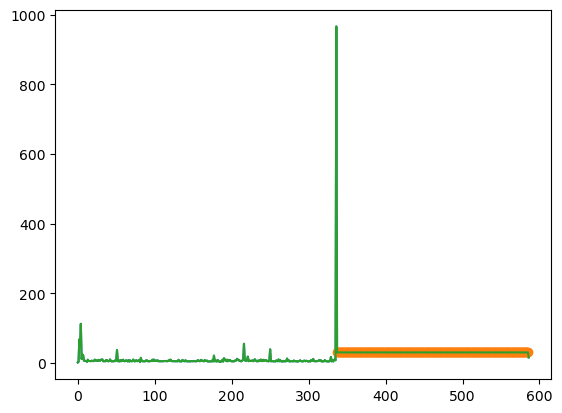

In [22]:
for run_index in range(len(final_files_to_process)):
    
    print('----------------NEXT DATA: --------------')
    file = final_files_to_process[run_index]
    full_file = final_full_files_to_process[run_index]
    
    current_amimal = full_file.split('\\')[-1].split('__')[0]
    
    date = full_file.split('\\')[-1].split('__')[-1]
    if '_' in date:
        date = date.split('_')[0]
    formatted_date = convert_date_format(date)
    
    full_cam_save_path = final_out_paths[run_index]
    
    
    # # TEMP - JUST FOR GETTING RID OF THE OLD FILES
    # for file in os.listdir(final_out_paths[run_index]):
    #     if file.split('_')[0] == 'camera':
    #         #delete file 
    #         os.remove(os.path.join(final_out_paths[run_index],file))
    # ##################################################
    
    print('**in data')
    print(os.path.join(full_file, file))

    print(current_amimal)
    print(formatted_date)
    
    print('**out dir')
    print(full_cam_save_path)
    
    ### PROCESS 
    
    print("**************** PROCESSING ****************")
    print(os.path.join(full_file, file))
    
    Camera_timestamps = pd.read_csv(os.path.join(full_file, file))



############ new way of processing camera data after Lars' changes to the data format

    Camera_timestamps.columns = ['trigger', 'timestamps', 'counter']
    Camera_timestamps.trigger = Camera_timestamps.trigger.astype(float)
    
    if len(str(Camera_timestamps.timestamps[0])) < 12:
        Camera_dataframe = process_camera_data(Camera_timestamps)
    else:
        # Convert timestamps to datetime
        Camera_timestamps['datetime'] = pd.to_datetime(Camera_timestamps['timestamps'], unit='ns')
        Camera_dataframe = pd.DataFrame({})
        Camera_dataframe['Trigger State'] = find_trigger_states(Camera_timestamps)
        Camera_dataframe['Time Stamps'] = (Camera_timestamps.datetime - Camera_timestamps.datetime[0]).dt.total_seconds()
        check_time_dropped(Camera_dataframe['Time Stamps'].values, Frame_rate = 60)
        
#########################################
    
    # if len(Camera_timestamps.columns) > 1:
    #     Camera_timestamps.columns = ['trigger', 'timestamps', 'blank']
    #     Camera_timestamps.trigger = Camera_timestamps.trigger.astype(float)
    # else:
    #     Camera_timestamps[['trigger', 'timestamps', 'blank']] = Camera_timestamps.iloc[:, 0].str.split(expand=True)
    #     Camera_timestamps.drop(Camera_timestamps.columns[0], axis=1, inplace=True)
    #     Camera_timestamps.trigger = Camera_timestamps.trigger.astype(float)
        
    # #check if timestmaps are reversed
    # if int(Camera_timestamps.timestamps.astype(float)[1] - Camera_timestamps.timestamps.astype(float)[0]) == 1:
    #     Camera_timestamps = Camera_timestamps.rename(columns={'timestamps': 'blank', 'blank': 'timestamps'})
        
    #     # Convert timestamps to datetime
    #     Camera_timestamps['datetime'] = pd.to_datetime(Camera_timestamps['timestamps'], unit='ns')
    
    #     Camera_dataframe = pd.DataFrame({})
    #     Camera_dataframe['Trigger State'] = find_trigger_states(Camera_timestamps)
    #     Camera_dataframe['Time Stamps'] = (Camera_timestamps.datetime - Camera_timestamps.datetime[0]).dt.total_seconds()
    #     check_time_dropped(Camera_dataframe['Time Stamps'].values, Frame_rate = 60)

    # else:
    #     Camera_dataframe = process_camera_data(Camera_timestamps)
    #     check_time_dropped(Camera_dataframe['Time Stamps'].values, Frame_rate = 60)
        
    ## split into 3 sperates epochs based on triggers
    # find trigger onset times
    trigger_changes = np.where(np.diff(Camera_dataframe['Trigger State'].values) == 1)[0]
    trigger_onset_times = Camera_dataframe['Time Stamps'].values[trigger_changes]

    np.diff(trigger_onset_times)
    sleep_trigger_inds = np.where((np.diff(trigger_onset_times) > 28.5) & (np.diff(trigger_onset_times) < 31.5))

    plt.plot(np.diff(trigger_onset_times))
    plt.plot(np.array(sleep_trigger_inds)[0],np.diff(trigger_onset_times)[sleep_trigger_inds],'o')

    consecutive_chunks = []
    start = None
    for i in range(len(sleep_trigger_inds[0]) - 1):
        if sleep_trigger_inds[0][i + 1] - sleep_trigger_inds[0][i] == 1:
            if start is None:
                start = sleep_trigger_inds[0][i]
        else:
            if start is not None:
                end = sleep_trigger_inds[0][i]
                consecutive_chunks.append((start, end))
                start = None
    if start is not None:
        consecutive_chunks.append((start, sleep_trigger_inds[0][-1]))

    # Remove any chunks that aren't at least 100 long
    consecutive_chunks = [(start, end) for start, end in consecutive_chunks if end - start >= 100]

    print(consecutive_chunks)

    ### determine video type:
    cam_path = None
#     for cam_file in os.listdir(full_file):
#         if '.avi' in cam_file:
    cam_path = os.path.join(full_file,file.split('.csv')[0]+'.avi')
    
            
#             try:
#                 if file.split('.csv')[0].split('timestamp')[1] in cam_file:
#                     cam_path = os.path.join(full_file,cam_file)
#             except:
#                 if file.split('.csv')[0].split('_')[0] in cam_file:
#                     cam_path = os.path.join(full_file,cam_file)
                    

    
    # # NICER but for one animal slightly error prone WAY BASED ON COUNTING CIRCLES IN FRAMES 
               
    # analyze the video based on cicles detected in frames 
    # start = trigger_onset_times[consecutive_chunks[0][-1]]
    # end = trigger_onset_times[consecutive_chunks[-1][0]]
    # circles_count = analyze_video_type(cam_path,start,end)


    # consecutive_threshold = 4
    # count_threshold = 5
    # consecutive_count = 0
    # BACK_CAM = False

    # for count in circles_count:
    #     if count > count_threshold:
    #         consecutive_count += 1
    #         if consecutive_count >= consecutive_threshold:
    #             BACK_CAM = True
    #             break
    #     else:
    #         consecutive_count = 0
    
    
    # temporary fix because for one animal the above auto thing doesnt work  
    BACK_CAM = False
    if 'camera2' in file or 'cam2' in file:
        BACK_CAM = True
    if 'timestamp_2' in file:
        BACK_CAM = True

    print(BACK_CAM)
    
    # plot the splits
    if BACK_CAM == True:
        plt.plot(np.diff(trigger_onset_times))  
        s = consecutive_chunks[0][-1]
        e = consecutive_chunks[-1][0]
        plt.fill_between(range(s, e), max(np.diff(trigger_onset_times)), np.diff(trigger_onset_times)[s:e], color='red', alpha=0.4)
    else:
        s = 0
        e = consecutive_chunks[0][-1]
        plt.fill_between(range(s, e), max(np.diff(trigger_onset_times)), np.diff(trigger_onset_times)[s:e], color='green', alpha=0.4)

        s = consecutive_chunks[-1][0]
        e = consecutive_chunks[-1][-1]
        plt.fill_between(range(s, e), max(np.diff(trigger_onset_times)), np.diff(trigger_onset_times)[s:e], color='yellow', alpha=0.4)
        
        
    # create dump file for processing the videos with DLC 
    DLC_dump_path_above = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\DLC_video_dump\ABOVE\\"
    if not os.path.exists(DLC_dump_path_above):
        os.makedirs(DLC_dump_path_above)
    DLC_dump_path_back = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\DLC_video_dump\BACK\\"
    if not os.path.exists(DLC_dump_path_back):
        os.makedirs(DLC_dump_path_back)
        

    ## save out cam dataframe: 
    trigger_onset_inds = Camera_dataframe.index.values[trigger_changes]
    behaviour_start = trigger_onset_inds[consecutive_chunks[0][-1]]
#     behaviour_start = trigger_onset_inds[0]
    behaviour_end = trigger_onset_inds[consecutive_chunks[-1][0]]
    # add epoch label column
    Camera_dataframe['epoch'] = ['presleep'] * behaviour_start + ['task'] * (behaviour_end - behaviour_start) + ['postsleep'] * (len(Camera_dataframe) - behaviour_end)
    # save this csv out unless it already exists:
    # if file already exists:
    if BACK_CAM == True:
        save_out_file = full_cam_save_path + "\BACK_camera_timestamp_df_" + current_amimal + '_' +formatted_date + '.csv'
    else:
        save_out_file = full_cam_save_path + "\ABOVE_camera_timestamp_df_" + current_amimal + '_' +formatted_date + '.csv'
    if not os.path.exists(save_out_file):
        Camera_dataframe.to_csv(save_out_file)
    else:
        print('file exists')
        print(save_out_file)

    #### copy the video to the correct location:
    if BACK_CAM == True:
        # Copy the video to organised folder
        new_file = full_cam_save_path + "\BACK_CAM_" + current_amimal + '_' +formatted_date + '.avi'
        shutil.copy(cam_path, new_file) 
        # copy to DLC dump location
        new_file = DLC_dump_path_back + "BACK_CAM_" + current_amimal + '_' +formatted_date + '.avi'
        shutil.copy(cam_path, new_file) 

    else:
        # Copy the video to organised folder
        new_file = full_cam_save_path + "\ABOVE_CAM_" + current_amimal + '_' +formatted_date + '.avi'
        shutil.copy(cam_path, new_file) 
        # copy to DLC dump location
        new_file = DLC_dump_path_above + "ABOVE_CAM_" + current_amimal + '_' +formatted_date + '.avi'
        shutil.copy(cam_path, new_file) 
        
    print(cam_path)

    print('done')
        
print('ALL DONE')

In [23]:
## save out cam dataframe: 
trigger_onset_inds = Camera_dataframe.index.values[trigger_changes]
# behaviour_start = trigger_onset_inds[consecutive_chunks[0][-1]]
behaviour_start = trigger_onset_inds[0]
behaviour_end = trigger_onset_inds[consecutive_chunks[-1][0]]
# add epoch label column
Camera_dataframe['epoch'] = ['presleep'] * behaviour_start + ['task'] * (behaviour_end - behaviour_start) + ['postsleep'] * (len(Camera_dataframe) - behaviour_end)
# save this csv out unless it already exists:
# if file already exists:
if BACK_CAM == True:
    save_out_file = full_cam_save_path + "\BACK_camera_timestamp_df_" + current_amimal + '_' +formatted_date + '.csv'
else:
    save_out_file = full_cam_save_path + "\ABOVE_camera_timestamp_df_" + current_amimal + '_' +formatted_date + '.csv'
if not os.path.exists(save_out_file):
    Camera_dataframe.to_csv(save_out_file)
else:
    print('file exists')
    print(save_out_file)

#### copy the video to the correct location:
if BACK_CAM == True:
    # Copy the video to organised folder
    new_file = full_cam_save_path + "\BACK_CAM_" + current_amimal + '_' +formatted_date + '.avi'
    shutil.copy(cam_path, new_file) 
    # copy to DLC dump location
    new_file = DLC_dump_path_back + "BACK_CAM_" + current_amimal + '_' +formatted_date + '.avi'
    shutil.copy(cam_path, new_file) 

else:
    # Copy the video to organised folder
    new_file = full_cam_save_path + "\ABOVE_CAM_" + current_amimal + '_' +formatted_date + '.avi'
    shutil.copy(cam_path, new_file) 
    # copy to DLC dump location
    new_file = DLC_dump_path_above + "ABOVE_CAM_" + current_amimal + '_' +formatted_date + '.avi'
    shutil.copy(cam_path, new_file) 

print(cam_path)

print('done')

Z:\projects\sequence_squad\revision_data\lars_recordings\video\\seq054\seq054__20250717_093349\seq054__20250717_093349__cam2.avi
done


In [142]:
cam_path = None

if '.avi' in cam_file:
    cam_path = os.path.join(full_file,file)


In [144]:
file

'seq052__20250618_092557__cam1.csv'

In [139]:
os.listdir(full_file)

['seq052__20250618_092557__cam1.avi',
 'seq052__20250618_092557__cam1.csv',
 'seq052__20250618_092557__cam2.avi',
 'seq052__20250618_092557__cam2.csv']

In [143]:
cam_file

'seq052__20250618_092557__cam2.csv'

In [135]:
cam_path

'Z:\\projects\\sequence_squad\\revision_data\\lars_recordings\\video\\\\seq052\\seq052__20250618_092557\\seq052__20250618_092557__cam1.csv'

In [130]:
DLC_dump_path_above

'Z:\\projects\\sequence_squad\\revision_data\\emmett_revisions\\DLC_video_dump\\ABOVE\\\\'

In [125]:
cam_path = None
for cam_file in os.listdir(full_file):
    if '.avi' in cam_file:
        cam_path = os.path.join(full_file,file)

In [126]:
cam_path

'Z:\\projects\\sequence_squad\\revision_data\\lars_recordings\\video\\\\seq052\\seq052__20250618_092557\\seq052__20250618_092557__cam1.csv'

In [121]:
full_file

'Z:\\projects\\sequence_squad\\revision_data\\lars_recordings\\video\\\\seq052\\seq052__20250618_092557'

In [91]:
BACK_CAM 

False

In [83]:
file

'seq059__20250617_083600__cam1.csv'

In [59]:
full_file, file

('Z:\\projects\\sequence_squad\\revision_data\\lars_recordings\\video\\\\seq059\\seq059__20250709_082401',
 'seq059__20250709_082401__cam1.csv')

In [53]:
consecutive_chunks

[(337, 585)]

In [52]:
behaviour_start = trigger_onset_inds[0]
behaviour_end = trigger_onset_inds[consecutive_chunks[-1][0]]
# add epoch label column
Camera_dataframe['epoch'] = ['presleep'] * behaviour_start + ['task'] * (behaviour_end - behaviour_start) + ['postsleep'] * (len(Camera_dataframe) - behaviour_end)
# save this csv out unless it already exists:
# if file already exists:
if BACK_CAM == True:
    save_out_file = full_cam_save_path + "\BACK_camera_timestamp_df_" + current_amimal + '_' +formatted_date + '.csv'
else:
    save_out_file = full_cam_save_path + "\ABOVE_camera_timestamp_df_" + current_amimal + '_' +formatted_date + '.csv'
if not os.path.exists(save_out_file):
    Camera_dataframe.to_csv(save_out_file)
else:
    print('file exists')
    print(save_out_file)

#### copy the video to the correct location:
if BACK_CAM == True:
    # Copy the video to organised folder
    new_file = full_cam_save_path + "\BACK_CAM_" + current_amimal + '_' +formatted_date + '.avi'
    shutil.copy(cam_path, new_file) 
    # copy to DLC dump location
    new_file = DLC_dump_path_back + "BACK_CAM_" + current_amimal + '_' +formatted_date + '.avi'
    shutil.copy(cam_path, new_file) 

else:
    # Copy the video to organised folder
    new_file = full_cam_save_path + "\ABOVE_CAM_" + current_amimal + '_' +formatted_date + '.avi'
    shutil.copy(cam_path, new_file) 
    # copy to DLC dump location
    new_file = DLC_dump_path_above + "ABOVE_CAM_" + current_amimal + '_' +formatted_date + '.avi'
    shutil.copy(cam_path, new_file) 

print('done')

done


In [17]:
Camera_dataframe

,Trigger State,Time Stamps
0,0.0,0.000000
1,0.0,0.016668
2,0.0,0.033337
3,0.0,0.050005
4,0.0,0.066673
...,...,...
965596,1.0,16094.778146
965597,1.0,16094.794814
965598,1.0,16094.811483
965599,1.0,16094.828151


# testing 

In [74]:
Camera_timestamps = pd.read_csv(r"Z:\projects\sequence_squad\revision_data\lars_recordings\video\seq059\seq059__20250618_085415\seq059__20250618_085415__cam1.csv")

if len(Camera_timestamps.columns) > 1:
    Camera_timestamps.columns = ['trigger', 'timestamps', 'counter']
    Camera_timestamps.trigger = Camera_timestamps.trigger.astype(float)
else:
    Camera_timestamps[['trigger', 'timestamps', 'counter']] = Camera_timestamps.iloc[:, 0].str.split(expand=True)
    Camera_timestamps.drop(Camera_timestamps.columns[0], axis=1, inplace=True)
    Camera_timestamps.trigger = Camera_timestamps.trigger.astype(float)
    
#check if timestmaps are reversed
# if int(Camera_timestamps.timestamps.astype(float)[1] - Camera_timestamps.timestamps.astype(float)[0]) == 1:
# Camera_timestamps = Camera_timestamps.rename(columns={'timestamps': 'blank', 'blank': 'timestamps'})

# Convert timestamps to datetime
Camera_timestamps['datetime'] = pd.to_datetime(Camera_timestamps['timestamps'], unit='ns')

Camera_dataframe = pd.DataFrame({})
Camera_dataframe['Trigger State'] = find_trigger_states(Camera_timestamps)
Camera_dataframe['Time Stamps'] = (Camera_timestamps.datetime - Camera_timestamps.datetime[0]).dt.total_seconds()
check_time_dropped(Camera_dataframe['Time Stamps'].values, Frame_rate = 60)

# # else:
# Camera_dataframe = process_camera_data(Camera_timestamps)
# check_time_dropped(Camera_dataframe['Time Stamps'].values, Frame_rate = 60)

Total frames dropped: 0
Total time dropped is approximatley: 0.0 seconds
0.0 seconds is equal to 0.0 hours, 0.0 minutes, and 0.0 seconds.


In [75]:
len(str(Camera_timestamps.timestamps[0]))

16

In [54]:
Camera_timestamps = pd.read_csv(os.path.join(full_file, file))

Camera_timestamps.columns = ['trigger', 'timestamps', 'counter']
Camera_timestamps.trigger = Camera_timestamps.trigger.astype(float)


9

In [57]:
np.diff(Camera_timestamps.timestamps)

array([ 546628,  545587,  545598, ...,  546623, 1332024,  545606],
      dtype=int64)

Frames dropped = 7


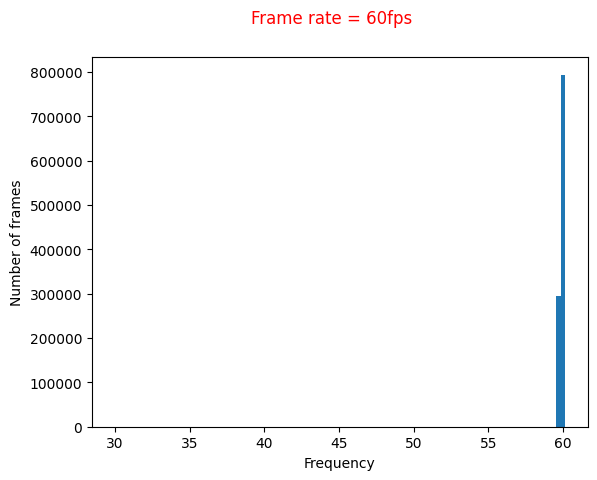

In [59]:
Camera_dataframe

,Time Stamps,Trigger State
0,0.000000,0.0
1,0.016750,0.0
2,0.033375,0.0
3,0.050000,0.0
4,0.066625,0.0
...,...,...
1087217,18111.810625,0.0
1087218,18111.827250,0.0
1087219,18111.844000,0.0
1087220,18111.860625,0.0


In [ ]:
Camera_dataframe

In [53]:
Camera_timestamps

,trigger,timestamps,counter
0,12.0,4306841515852840,11112373
1,12.0,4306841532521656,11112374
2,12.0,4306841549189384,11112375
3,12.0,4306841565857880,11112376
4,12.0,4306841582525896,11112377
...,...,...,...
1030923,12.0,4324025179591184,12143296
1030924,12.0,4324025196260088,12143297
1030925,12.0,4324025212928232,12143298
1030926,12.0,4324025229595656,12143299


In [ ]:
Camera_dataframe[]

,Time Stamps,Trigger State
0,0.000000,0.0
1,0.508625,0.0
2,0.993375,0.0
3,1.502000,0.0
4,1.986625,0.0
...,...,...
1030923,512113.088625,0.0
1030924,512113.597250,0.0
1030925,512114.082000,0.0
1030926,512114.590625,0.0


In [52]:
(512115.075250/ 60)/60

142.25418756944447

In [47]:
286.39550685/60

4.7732584475

(10000.0, 22000.0)

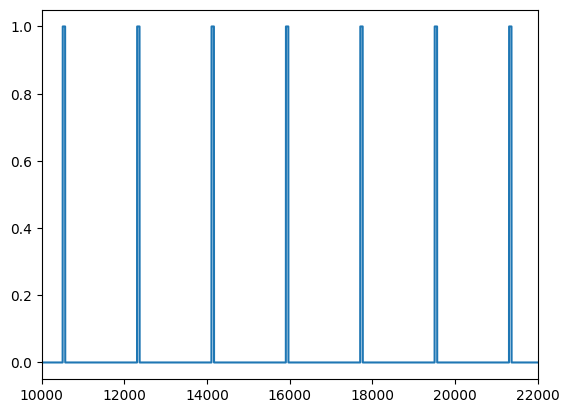

In [66]:
plt.plot(Camera_dataframe['Trigger State'])
plt.xlim(10000, 22000)

In [71]:
Camera_timestamps = pd.read_csv(r"Z:\projects\sequence_squad\revision_data\lars_recordings\video\seq054\seq054__20250616_111737\seq054__20250616_111737__cam1.csv")


In [73]:
Camera_timestamps

,805306368,390285061,36901885
0,805306368,399018734,36901901
1,805306368,399565351,36901902
2,805306368,400110949,36901903
3,805306368,400656548,36901904
4,805306368,401202148,36901905
...,...,...,...
151416,805306368,3432945984,37053317
151417,805306368,3433492697,37053318
151418,805306368,3434038296,37053319
151419,805306368,3434583894,37053320


In [19]:
Camera_timestamps = pd.read_csv(os.path.join(full_file, file))

In [21]:
os.path.join(full_file, file)

'Z:\\projects\\sequence_squad\\revision_data\\lars_recordings\\video\\\\seq006\\seq006__20241118\\seq006__20241118__timestamp_02024-11-18T13_11_58.csv'

In [20]:
Camera_timestamps

,Item1,Item2,Item3
0,12,29467105,603341573504936
1,12,29467106,603341579380960
2,12,29467107,603341585255952
3,12,29467108,603341591131128
4,12,29467109,603341597006008
...,...,...,...
2606459,12,32073564,619897388967864
2606460,12,32073565,619897394842768
2606461,12,32073566,619897400717896
2606462,12,32073567,619897406593088


In [17]:
Camera_dataframe

NameError: name 'Camera_dataframe' is not defined

# testing area: 

In [ ]:
##### OLD METHOD OF SPLITTING INTO 3 FILES (DOESNT WORK PROPERLY BECAUSE FFMPEG DOESNT NEATLY CUT THE VIDEO, IT CUTS IT AT THE CLOSEST FRAME AND THIS MESSES UP THE TIMINGS)
   
    if BACK_CAM == True:
        # save out task
        start = trigger_onset_times[consecutive_chunks[0][-1]]
        end = trigger_onset_times[consecutive_chunks[-1][0]]
        print(start,end)
        ffmpeg_extract_subclip(cam_path, start, end, full_cam_save_path_task + "\BACK_task_" + current_amimal + '_' +formatted_date + '_subclip_' + str(start) + '-' + str(end) + '.avi')
        # Copy the saved video to another location
        shutil.copy(full_cam_save_path_task + "\BACK_task_" + current_amimal + '_' +formatted_date + '_subclip_' + str(start) + '-' + str(end) + '.avi', DLC_dump_path_back) 
        # save out csv
        task_camera_dataframe.to_csv(full_cam_save_path_task + "\BACK_task_" + current_amimal + '_' +formatted_date + '_subclip_' + str(start) + '-' + str(end) + '.csv')
        
    else:
        ## save out sleep1
        start = 0 
        end = trigger_onset_times[consecutive_chunks[0][-1]]
        print(start,end)
        ffmpeg_extract_subclip(cam_path, start, end, full_cam_save_path_pre + "\ABOVE_presleep_" + current_amimal + '_' +formatted_date + '_subclip_' + str(start) + '-' + str(end) + '.avi')
        # Copy the saved video to another location
        shutil.copy(full_cam_save_path_pre + "\ABOVE_presleep_" + current_amimal + '_' +formatted_date + '_subclip_' + str(start) + '-' + str(end) + '.avi', DLC_dump_path_above)
        # save out csv
        presleep_camera_dataframe.to_csv(full_cam_save_path_pre + "\ABOVE_presleep_" + current_amimal + '_' +formatted_date + '_subclip_' + str(start) + '-' + str(end) + '.csv')

        
        # save out postsleep
        start = trigger_onset_times[consecutive_chunks[-1][0]]
        end = trigger_onset_times[consecutive_chunks[-1][-1]]
        print(start,end)
        ffmpeg_extract_subclip(cam_path, start, end, full_cam_save_path_post + "\ABOVE_postleep_" + current_amimal + '_' +formatted_date + '_subclip_' + str(start) + '-' + str(end) + '.avi')
        # Copy the saved video to another location
        shutil.copy(full_cam_save_path_post + "\ABOVE_postleep_" + current_amimal + '_' +formatted_date + '_subclip_' + str(start) + '-' + str(end) + '.avi', DLC_dump_path_above)
        # save out csv
        postsleep_camera_dataframe.to_csv(full_cam_save_path_post + "\ABOVE_postleep_" + current_amimal + '_' +formatted_date + '_subclip_' + str(start) + '-' + str(end) + '.csv')
        
    print('done')

Frames dropped = 64
Total frames dropped: 64
Total time dropped is approximatley: 60.920958333332415 seconds
60.920958333332415 seconds is equal to 0.0 hours, 1.0 minutes, and 0.9209583333324147 seconds.


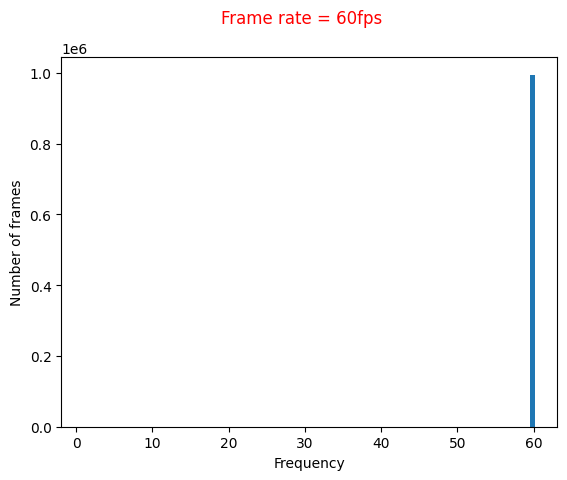

In [ ]:
save_path_base = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"
# full_file = r"D:\video_testing\seq006__20241114\\"
full_file = r"D:\video_testing\AP5_1_L__20241119\\"

# file = "seq006__20241114__timestamp_02024-11-14T09_26_38.csv"
# file = "seq006__20241114__timestamp_22024-11-14T09_26_38.csv"

file = "camera2_2024-11-19T14_18_45.csv"




Camera_timestamps = pd.read_csv(os.path.join(full_file, file))

# Camera_timestamps = pd.read_csv(os.path.join(r"D:\video_testing\AP5_1_L__20241119\camera1_2024-11-19T14_18_45.csv"))

if len(Camera_timestamps.columns) > 1:
    Camera_timestamps.columns = ['trigger', 'timestamps', 'blank']
    Camera_timestamps.trigger = Camera_timestamps.trigger.astype(float)
else:
    Camera_timestamps[['trigger', 'timestamps', 'blank']] = Camera_timestamps.iloc[:, 0].str.split(expand=True)
    Camera_timestamps.drop(Camera_timestamps.columns[0], axis=1, inplace=True)
    Camera_timestamps.trigger = Camera_timestamps.trigger.astype(float)
    
#check if timestmaps are reversed
if int(Camera_timestamps.timestamps.astype(float)[1] - Camera_timestamps.timestamps.astype(float)[0]) == 1:
    Camera_timestamps = Camera_timestamps.rename(columns={'timestamps': 'blank', 'blank': 'timestamps'})
    
    # Convert timestamps to datetime
    Camera_timestamps['datetime'] = pd.to_datetime(Camera_timestamps['timestamps'], unit='ns')

    Camera_dataframe = pd.DataFrame({})
    Camera_dataframe['Trigger State'] = find_trigger_states(Camera_timestamps)
    Camera_dataframe['Time Stamps'] = (Camera_timestamps.datetime - Camera_timestamps.datetime[0]).dt.total_seconds()
    check_time_dropped(Camera_dataframe['Time Stamps'].values, Frame_rate = 60)

else:
    Camera_dataframe = process_camera_data(Camera_timestamps)
    check_time_dropped(Camera_dataframe['Time Stamps'].values, Frame_rate = 60)